In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

#### Get MNIST data

In [3]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,)),
])

dataset = datasets.MNIST('./', transform=transform, download=True)

In [5]:
dataloader = DataLoader(dataset, batch_size=128, pin_memory=True, shuffle=True)

#### Define simple GAN

In [36]:
class Generator(nn.Module):
	def __init__(self, latent, img_dim):
		super().__init__()
		self.gen = nn.Sequential(
			nn.Linear(latent, 256),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(256, 512),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(512, img_dim),
			nn.Tanh()
		)

	def forward(self, x):
		return self.gen(x)


class Discriminator(nn.Module):
	def __init__(self, img_dim):
		super().__init__()
		self.dis = nn.Sequential(
			nn.Flatten(),
			nn.Linear(img_dim, 512),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(512, 256),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(256, 1),
			nn.Sigmoid()
		)


	def forward(self, x):
		return self.dis(x)

In [37]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [38]:
writer_fake = SummaryWriter(f"./runs/GAN/fake_faces")
writer_real = SummaryWriter(f'./runs/GAN/real_faces')

In [39]:
latent_dim = 64
img_dim = 28 * 28
model = {
	"gen" : Generator(latent_dim, img_dim).to(device),
	"dis" : Discriminator(img_dim).to(device)
}
optimizer = {
	"gen" : torch.optim.Adam(model['gen'].parameters(), lr = 1e-4, amsgrad=True, betas=(0.5, 0.999)),
	"dis" : torch.optim.Adam(model['dis'].parameters(), lr = 1e-4, amsgrad=True, betas=(0.5, 0.999))
}
loss_fn = torch.nn.BCELoss()

In [40]:
def train(model, loss_fn, epochs):
	torch.mps.empty_cache()
	loss_gen = []
	loss_dis = []
	real_score = []
	fake_score = []
	model["gen"].train()
	model["dis"].train()

	fixed_noise = torch.randn(32, latent_dim).to(device)

	for epoch in tqdm(range(epochs)):
		loss_gen_e = []
		loss_dis_e = []
		fake_score_e = []
		real_score_e = []
		for batch_idx, (real_imgs, _) in enumerate(dataloader):
			optimizer["dis"].zero_grad()
			real_imgs = real_imgs.to(device)

			# Train discriminator
			# Real images
			real_preds = model["dis"](real_imgs).view(-1)
			real_loss = loss_fn(real_preds, torch.ones_like(real_preds).to(device))
			
			# Fake images
			latent = torch.randn(real_imgs.size(0), latent_dim).to(device)
			fake_imgs = model["gen"](latent)
			fake_preds = model["dis"](fake_imgs.detach()).view(-1)
			fake_loss = loss_fn(fake_preds, torch.zeros_like(fake_preds).to(device))
			cur_fake_score = torch.mean(fake_loss.detach()).item()
			cur_real_score = torch.mean(real_loss.detach()).item()

			fake_score_e.append(cur_real_score)
			real_score_e.append(cur_fake_score)

			cur_loss_dis = (real_loss + fake_loss) / 2
			cur_loss_dis.backward()
			optimizer["dis"].step()
			loss_dis_e.append(cur_loss_dis.item())

			# Train generator
			optimizer["gen"].zero_grad()
			latent = torch.randn(real_imgs.size(0), latent_dim).to(device)
			fake_imgs = model["gen"](latent)
			preds = model["dis"](fake_imgs).view(-1)
			cur_loss_gen = loss_fn(preds, torch.ones_like(preds))
			cur_loss_gen.backward()
			optimizer["gen"].step()
			loss_gen_e.append(cur_loss_gen.item())


			if batch_idx == 0:
				with torch.no_grad():
					fake = model["gen"](fixed_noise)
					fake = fake.reshape(-1, 1, 28, 28)
					data = real_imgs[:32]
					img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
					img_grid_real = torchvision.utils.make_grid(data, normalize=True)

					writer_fake.add_image(
						"Faces fake", img_grid_fake, global_step=epoch
					)
					writer_real.add_image("Faces real", img_grid_real, global_step=epoch)
		
		loss_gen.append(np.mean(loss_gen_e))
		loss_dis.append(np.mean(loss_dis_e))
		fake_score.append(np.mean(fake_score_e))
		real_score.append(np.mean(real_score_e))

		print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
			epoch+1, epochs, 
			loss_gen[-1], loss_dis[-1], real_score[-1], fake_score[-1]))

	return loss_gen, loss_dis, real_score, fake_score

In [41]:
hist = train(model, loss_fn, 40)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 1.2784, loss_d: 0.3960, real_score: 0.5668, fake_score: 0.2252
Epoch [2/40], loss_g: 2.1055, loss_d: 0.2990, real_score: 0.3416, fake_score: 0.2564
Epoch [3/40], loss_g: 2.2751, loss_d: 0.3201, real_score: 0.3276, fake_score: 0.3127
Epoch [4/40], loss_g: 2.5797, loss_d: 0.2277, real_score: 0.2201, fake_score: 0.2353
Epoch [5/40], loss_g: 2.9649, loss_d: 0.1843, real_score: 0.1668, fake_score: 0.2019
Epoch [6/40], loss_g: 3.0807, loss_d: 0.1958, real_score: 0.1764, fake_score: 0.2152
Epoch [7/40], loss_g: 2.8545, loss_d: 0.1905, real_score: 0.1702, fake_score: 0.2107
Epoch [8/40], loss_g: 2.9584, loss_d: 0.2047, real_score: 0.1740, fake_score: 0.2354
Epoch [9/40], loss_g: 2.9392, loss_d: 0.1997, real_score: 0.1679, fake_score: 0.2314
Epoch [10/40], loss_g: 3.0200, loss_d: 0.1820, real_score: 0.1574, fake_score: 0.2066
Epoch [11/40], loss_g: 3.2981, loss_d: 0.1509, real_score: 0.1273, fake_score: 0.1746
Epoch [12/40], loss_g: 3.3393, loss_d: 0.1443, real_score: 0.11

#### Let's see on our training graphs

In [43]:
def plot_train_func(loss_generator, loss_discriminator, real_score, fake_score):
    d = {0: loss_generator, 1: loss_discriminator, 2: real_score, 3 : fake_score}
    names = {0: "Generator Loss", 1: "Discriminator Loss", 2: "Real score", 3 : "Fake score"}
    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    for i in range(4):
        ax[i].plot(d[i])
        ax[i].grid()
        ax[i].set_title(names[i])
    plt.show()

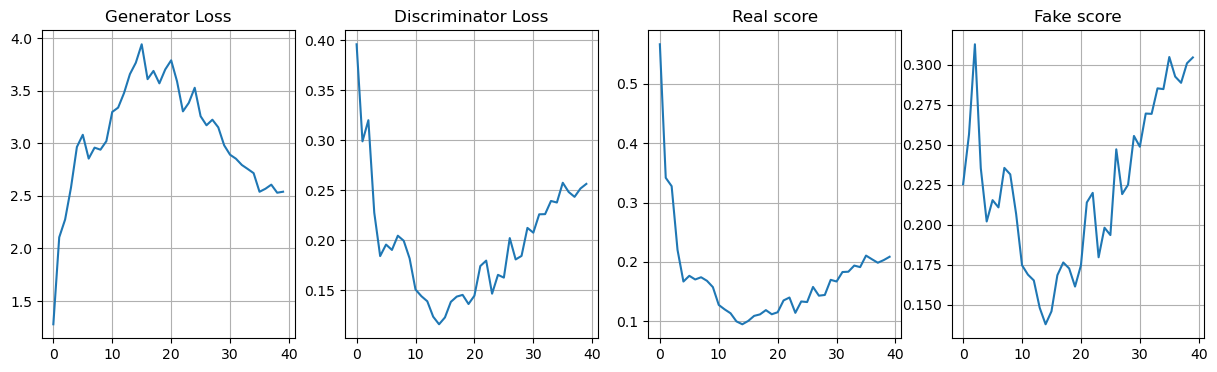

In [44]:
plot_train_func(*hist)

#### And let's take a look on generated images

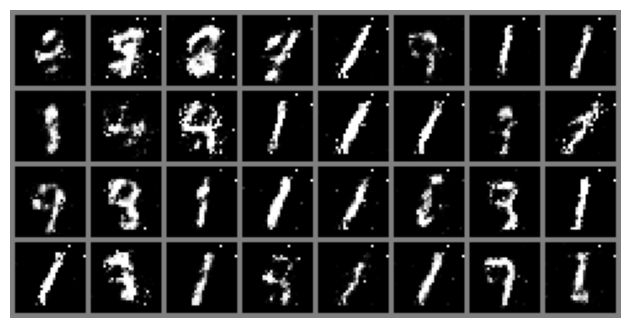

In [51]:
latent = torch.randn(32, latent_dim).to(device)
fake_pictures = model['gen'](latent).view(-1, 1, 28, 28)

fake_imgs = torchvision.utils.make_grid(fake_pictures)[0].detach().cpu()
plt.figure(figsize=(14, 4))
plt.imshow(fake_imgs, cmap='gray')
plt.axis("off")
plt.show()

#### As we can see our simple GAN model can generate numbers from MNIST.
It's generate 1 perfectly, also we can see 7,9.4 on this image